In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

import tensorflow_text as text

from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization

import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

TF Version:  2.8.0
Eager mode:  True
Hub version:  0.12.0
GPU is available


In [3]:
train_df = pd.read_csv('datasets/E-c-En-train.csv')
test_df = pd.read_csv('datasets/E-c-En-dev.csv')

train_df.shape

(6838, 13)

In [4]:
train_df.drop('ID',axis=1, inplace=True)
test_df.drop('ID',axis=1, inplace=True)
train_df

,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,“Worry is a down payment on a problem you may ...,0,1,0,0,0,0,1,0,0,0,1
1,Whatever you decide to do make sure it makes y...,0,0,0,0,1,1,1,0,0,0,0
2,@Max_Kellerman it also helps that the majorit...,1,0,1,0,1,0,1,0,0,0,0
3,Accept the challenges so that you can literall...,0,0,0,0,1,0,1,0,0,0,0
4,My roommate: it's okay that we can't spell bec...,1,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
6833,@nicky57672 Hi! We are working towards your hi...,0,0,0,0,0,0,0,0,0,0,0
6834,@andreamitchell said @berniesanders not only d...,0,1,0,0,0,0,0,0,0,1,0
6835,@isthataspider @dhodgs i will fight this guy! ...,1,0,1,0,0,0,0,1,0,0,0
6836,i wonder how a guy can broke his penis while h...,0,0,0,0,0,0,0,0,0,1,0


In [5]:
def get_targets(df):
    target = []

    for i in range(len(df)):
        onehot = df[df.columns[1:]].loc[i].values
        target.append(onehot)

    return target

In [6]:
train_df['target'] = get_targets(train_df)

In [7]:
test_df['target'] = get_targets(test_df)

In [8]:
train_df 

,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust,target
0,“Worry is a down payment on a problem you may ...,0,1,0,0,0,0,1,0,0,0,1,"[0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]"
1,Whatever you decide to do make sure it makes y...,0,0,0,0,1,1,1,0,0,0,0,"[0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0]"
2,@Max_Kellerman it also helps that the majorit...,1,0,1,0,1,0,1,0,0,0,0,"[1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0]"
3,Accept the challenges so that you can literall...,0,0,0,0,1,0,1,0,0,0,0,"[0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0]"
4,My roommate: it's okay that we can't spell bec...,1,0,1,0,0,0,0,0,0,0,0,"[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6833,@nicky57672 Hi! We are working towards your hi...,0,0,0,0,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
6834,@andreamitchell said @berniesanders not only d...,0,1,0,0,0,0,0,0,0,1,0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
6835,@isthataspider @dhodgs i will fight this guy! ...,1,0,1,0,0,0,0,1,0,0,0,"[1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0]"
6836,i wonder how a guy can broke his penis while h...,0,0,0,0,0,0,0,0,0,1,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"


In [9]:
test_df.columns

Index(['Tweet', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'love',
       'optimism', 'pessimism', 'sadness', 'surprise', 'trust', 'target'],
      dtype='object')

In [10]:
import re

In [11]:
import emoji

# Function for converting emojis into words
def convert_emojis(text):
    text = emoji.demojize(text)
    return text

In [12]:
train_df['Tweet'] = train_df['Tweet'].map(lambda x : convert_emojis(x))
test_df['Tweet'] = test_df['Tweet'].map(lambda x : convert_emojis(x))

In [13]:
def clean_text(text):
    #converts to lower case
    text = text.lower()
    #remove tags
    text = re.sub('\S*@\S*', ' ', text)
    #remove contractions and remove space
    text = re.sub('\'', '', text)
    #remove all special characters except for ? and !
    text = re.sub('[^A-Za-z!?]', ' ', text)
    # removes numbers
    text = re.sub('\w*\d\w*', ' ', text) 
    # substitutes _ with a space
    text = re.sub('_', ' ', text)
    # Substituting multiple spaces with single space
    text = re.sub('\s+', ' ', text)
    #removes blank space at start of text
    text = text.strip(' ') 
    return text

In [14]:
clean_text('\/# ?? !! @word blah blah\'s')

'?? !! blah blahs'

In [15]:
train_df['Tweet'] = train_df['Tweet'].map(lambda x : clean_text(x))
test_df['Tweet'] = test_df['Tweet'].map(lambda x : clean_text(x))

In [16]:
train_df['Tweet'][:20].to_list()

['worry is a down payment on a problem you may never have joyce meyer motivation leadership worry',
 'whatever you decide to do make sure it makes you happy',
 'it also helps that the majority of nfl coaching is inept some of bill obriens play calling was wow ! gopats',
 'accept the challenges so that you can literally even feel the exhilaration of victory george s patton dog face',
 'my roommate its okay that we cant spell because we have autocorrect terrible firstworldprobs',
 'no but thats so cute atsu was probably shy about photos before but cherry helped her out uwu',
 'do you think humans have the sense for recognizing impending doom?',
 'rooneys fucking untouchable isnt he? been fucking dreadful again depay has looked decent ish tonight',
 'its pretty depressing when u hit pan on ur favourite highlighter',
 'but your pussy was weak from what i heard so stfu up to me bitch you got to threaten him that your pregnant',
 'making that yearly transition from excited and hopeful colleg

In [17]:
train_df['target'].values

array([array([0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1], dtype=int64),
       array([0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0], dtype=int64),
       array([1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0], dtype=int64), ...,
       array([1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0], dtype=int64),
       array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], dtype=int64),
       array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], dtype=int64)],
      dtype=object)

In [18]:
# tokenizer.wordpiece_tokenizer.tokenize(train_df['Tweet'][0])

In [19]:
# tokenizer.convert_tokens_to_ids(tokenizer.wordpiece_tokenizer.tokenize(train_df['Tweet'][0]))

In [20]:
# import tarfile

# my_tar = tarfile.open('bert_en_uncased_preprocess_3.tar.gz')
# my_tar.extractall('./preprocess')
# my_tar.close

In [21]:
bert_model_name = 'bert_en_uncased_L-12_H-768_A-12_4'

map_name_to_handle = {'bert_en_uncased_L-12_H-768_A-12_4': "bert_uncased"}

map_model_to_preprocess = {'bert_en_uncased_L-12_H-768_A-12_4': "preprocess"}

In [22]:
tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

In [23]:
bert_preprocess = hub.load(tfhub_handle_preprocess)
tok = bert_preprocess.tokenize(tf.constant([train_df['Tweet'][0]]))
print(tok)

<tf.RaggedTensor [[[4737],
  [2003],
  [1037],
  [2091],
  [7909],
  [2006],
  [1037],
  [3291],
  [2017],
  [2089],
  [2196],
  [2031],
  [11830],
  [11527],
  [14354],
  [4105],
  [4737]]]>


In [24]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.4)(net)
    net = tf.keras.layers.Dense(768)(net)
    net = tf.keras.layers.Dropout(0.4)(net)
    net = tf.keras.layers.Dense(384)(net)
    net = tf.keras.layers.Dropout(0.4)(net)
    net = tf.keras.layers.Dense(11, activation='sigmoid', name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [25]:
classifier_model = build_classifier_model()

In [26]:
# text_test = [train_df['Tweet'][0]]

# bert_raw_result = classifier_model(tf.constant(text_test))
# print(tf.sigmoid(bert_raw_result))

In [26]:
train_x = train_df['Tweet']
train_y = train_df.loc[:,['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love',
       'optimism', 'pessimism', 'sadness', 'surprise', 'trust']].values
test_x = test_df['Tweet']
test_y = test_df.loc[:,['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love',
       'optimism', 'pessimism', 'sadness', 'surprise', 'trust']].values

In [27]:
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((6838,), (6838, 11), (886,), (886, 11))

In [28]:
train_x

0       worry is a down payment on a problem you may n...
1       whatever you decide to do make sure it makes y...
2       it also helps that the majority of nfl coachin...
3       accept the challenges so that you can literall...
4       my roommate its okay that we cant spell becaus...
                              ...                        
6833    hi! we are working towards your highlighted co...
6834    said not only did not play up hrc in campaigni...
6835    i will fight this guy! dont insult the lions l...
6836    i wonder how a guy can broke his penis while h...
6837        im highly animated even though im decomposing
Name: Tweet, Length: 6838, dtype: object

In [29]:
train_y.shape

(6838, 11)

In [30]:
tf.keras.backend.clear_session()

classifier_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.BinaryAccuracy()])

In [31]:
classifier_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

In [31]:
epochs = 3
batch_size = 32

In [32]:
history = classifier_model.fit(train_x,
                               train_y,
                               validation_data=[test_x, test_y],
                               batch_size = batch_size,
                               epochs=epochs,
                               verbose = 1)

Epoch 1/3
214/214 [==============================] - 79s 311ms/step - loss: 0.5166 - binary_accuracy: 0.7613 - val_loss: 0.3819 - val_binary_accuracy: 0.8340
Epoch 2/3
214/214 [==============================] - 66s 309ms/step - loss: 0.3787 - binary_accuracy: 0.8428 - val_loss: 0.3063 - val_binary_accuracy: 0.8719
Epoch 3/3
214/214 [==============================] - 66s 307ms/step - loss: 0.3128 - binary_accuracy: 0.8733 - val_loss: 0.3006 - val_binary_accuracy: 0.8789


In [33]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    plt.show()

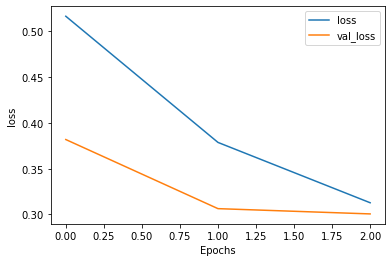

In [34]:
plot_graphs(history, 'loss')

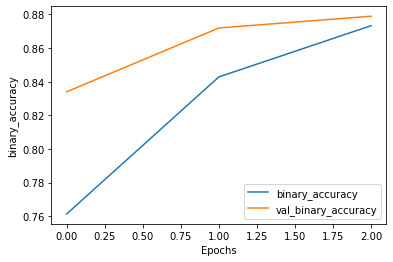

In [35]:
plot_graphs(history, 'binary_accuracy')

In [36]:
emotions = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love',
       'optimism', 'pessimism', 'sadness', 'surprise', 'trust']

In [37]:
tweet_no = 4

text_test = [train_df['Tweet'][tweet_no]]

preds = classifier_model.predict([text_test])
print(text_test)

pred_dict = {}
for emotion, value in zip(emotions, preds.round()[0]):
    pred_dict[emotion] = value
    
print(pred_dict)
train_df.loc[tweet_no:tweet_no, emotions]

['my roommate its okay that we cant spell because we have autocorrect terrible firstworldprobs']
{'anger': 1.0, 'anticipation': 0.0, 'disgust': 1.0, 'fear': 0.0, 'joy': 0.0, 'love': 0.0, 'optimism': 0.0, 'pessimism': 0.0, 'sadness': 0.0, 'surprise': 0.0, 'trust': 0.0}


,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
4,1,0,1,0,0,0,0,0,0,0,0


In [38]:
preds = classifier_model.predict(train_df['Tweet'])

In [39]:
preds = pd.DataFrame(data = preds, columns = emotions)

In [40]:
preds = preds.round()

In [41]:
from sklearn.metrics import accuracy_score

accuracies = []

for emotion in emotions:
    acc = accuracy_score(train_df[emotion], preds[emotion])
    accuracies.append(acc)
    print(acc)

0.9012869260017549
0.8622404211757824
0.8711611582334016
0.9346300087744954
0.9100614214682656
0.9265867212635274
0.8675051184556888
0.8960222287218484
0.8559520327581164
0.9472067856098274
0.9477917519742615


In [42]:
np.mean(accuracies)

0.9018585976760881

In [43]:
test_df

,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust,target
0,oh hidden revenge and anger i rememberthe time...,1,0,1,0,0,0,0,0,0,0,0,"[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]"
1,im doing all this to make sure you smiling dow...,0,0,0,0,1,1,1,0,0,0,0,"[0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0]"
2,if not then teamchristine bc all tana has done...,1,0,1,0,0,0,0,0,0,0,0,"[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]"
3,it is a great start for beginners to jump into...,0,0,0,0,1,0,1,0,0,0,0,"[0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0]"
4,my best friends driving for the first time wit...,0,0,0,1,0,0,0,0,0,0,0,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
881,if this didnt make me so angry id be laughing ...,1,0,1,0,0,0,0,0,0,0,0,"[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]"
882,excited to watch stateoforigin tonight! come o...,0,0,0,0,1,0,1,0,0,0,0,"[0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0]"
883,blah blah blah kyrie it etc leaving boston is ...,1,0,1,0,0,0,0,0,1,0,0,"[1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0]"
884,thingsivelearned the wise shepherd never trust...,0,0,0,0,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [44]:
test_preds = classifier_model.predict(test_df['Tweet'])
test_preds = pd.DataFrame(data = test_preds, columns = emotions)
test_preds = test_preds.round()

In [45]:
len(test_preds)

886

In [46]:
from sklearn.metrics import accuracy_score

test_accuracies = []

for emotion in emotions:
    acc = accuracy_score(test_df[emotion], test_preds[emotion])
    test_accuracies.append(acc)
    print(acc)

0.8306997742663657
0.863431151241535
0.835214446952596
0.9221218961625283
0.8589164785553047
0.8927765237020316
0.8261851015801355
0.8939051918735892
0.8329571106094809
0.9604966139954854
0.9514672686230248


In [47]:
np.mean(test_accuracies)

0.8789246870510979

In [48]:
train_df

,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust,target
0,worry is a down payment on a problem you may n...,0,1,0,0,0,0,1,0,0,0,1,"[0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]"
1,whatever you decide to do make sure it makes y...,0,0,0,0,1,1,1,0,0,0,0,"[0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0]"
2,it also helps that the majority of nfl coachin...,1,0,1,0,1,0,1,0,0,0,0,"[1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0]"
3,accept the challenges so that you can literall...,0,0,0,0,1,0,1,0,0,0,0,"[0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0]"
4,my roommate its okay that we cant spell becaus...,1,0,1,0,0,0,0,0,0,0,0,"[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6833,hi! we are working towards your highlighted co...,0,0,0,0,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
6834,said not only did not play up hrc in campaigni...,0,1,0,0,0,0,0,0,0,1,0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
6835,i will fight this guy! dont insult the lions l...,1,0,1,0,0,0,0,1,0,0,0,"[1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0]"
6836,i wonder how a guy can broke his penis while h...,0,0,0,0,0,0,0,0,0,1,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"


In [49]:
classifier_model.predict(tf.constant(text_test))

array([[0.9719704 , 0.02185929, 0.96261066, 0.1065757 , 0.01737868,
        0.00737525, 0.00824684, 0.0806017 , 0.44645438, 0.02475912,
        0.00371768]], dtype=float32)

In [50]:
tok = bert_preprocess.tokenize(tf.constant([train_df['Tweet'][5]]))
print(tok)

<tf.RaggedTensor [[[2053], [2021], [2008, 2015], [2061], [10140], [2012, 6342], [2001],
  [2763], [11004], [2055], [7760], [2077], [2021], [9115], [3271], [2014],
  [2041], [1057, 16050]]]>


In [ ]:
def to_feature_map(text, label):
    input_ids, input_mask, segment_ids, label_id = tf.py_function(to_feature, inp=[text, label],
                                                                Tout=[tf.int32,tf.int32,tf.int32,tf.int32])
    input_ids.set_shape([max_seq_length])
    input_mask.set_shape([max_seq_length])
    segment_ids.set_shape([max_seq_length])
    label_id.set_shape([])

    x = {
      'input_word_ids' : input_ids,
       'input_mask': input_mask,
       'input_type_ids': segment_ids
    }

    return x

In [ ]:
to_feature_map('hello there how are you', 1)

In [ ]:
with tf.device('/cpu:0'):
    # train
    train_data = (train_data.map(to_feature_map,
                               num_parallel_calls = tf.data.experimental.AUTOTUNE)
    .shuffle(1000)
    .batch(16, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))                              

    # valid
    valid_data = (valid_data.map(to_feature_map,
                               num_parallel_calls = tf.data.experimental.AUTOTUNE)
    .batch(16, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

In [ ]:
# train data spec
train_data.element_spec

In [ ]:
# valid data spec
valid_data.element_spec

In [ ]:
# use mlp for prediction on multi-label classification
from numpy import asarray
from sklearn.datasets import make_multilabel_classification
from keras.models import Sequential
from keras.layers import Dense

# get the dataset
def get_dataset():
	X, y = make_multilabel_classification(n_samples=1000, n_features=10, n_classes=3, n_labels=2, random_state=1)
	return X, y

# get the model
def get_model(n_inputs, n_outputs):
	model = Sequential()
	model.add(Dense(20, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
	model.add(Dense(n_outputs, activation='sigmoid'))
	model.compile(loss='binary_crossentropy', optimizer='adam')
	return model

# load dataset
X, y = get_dataset()
n_inputs, n_outputs = X.shape[1], y.shape[1]
# get model
model = get_model(n_inputs, n_outputs)
# fit the model on all data
model.fit(X, y, verbose=0, epochs=100)
# make a prediction for new data
row = [3, 3, 6, 7, 8, 2, 11, 11, 1, 3]
newX = asarray([row])
yhat = model.predict(newX)
print('Predicted: %s' % yhat[0])

In [ ]:
n_inputs, n_outputs

In [4]:
1/2*5*(1+1)

5.0

In [5]:
1/2*(1+1)*5

5.0